In [1]:
import os
import random
import time
import glob
import json
import dit
import itertools
import time
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
os.chdir("../")
from helpers.group_helpers import classify_syms, srv_to_mat
from helpers.compare_helpers import appendtoPXS,load_frame,addbestsym
from jointpdfpython3.measures import synergistic_entropy_upper_bound, append_random_srv
from jointpdfpython3.params_matrix import params2matrix_incremental,matrix2params_incremental
from jointpdfpython3.JointProbabilityMatrix import JointProbabilityMatrix
from syndisc.syndisc import self_disclosure_channel

os.chdir("./plot_notebooks")

import seaborn as sns;sns.set()

In [3]:
dist_type = 'scipyparx'
ds = []
folder = '../../results/test/'
os.chdir(folder)
allfiles = glob.glob("*.pkl")
files = [file for file in allfiles if dist_type in file]
if len(files) != 0:
    cur = []
    for f in files:
        cur.append(pd.read_pickle(f))
os.chdir('../../code/plot_notebooks')
d = pd.concat(cur)

def synsyns(row):
    jX = JointProbabilityMatrix(2,row['states'],joint_probs='iid')
    params2matrix_incremental(jX, row['parX'])
    row['H(X0)'] = jX.entropy([0])
    row['H(X1)'] = jX.entropy([1]) 
    row['I(X0;X1)'] = jX.mutual_information([0],[1])
    row['I(X0;X1) level'] = row['I(X0;X1)']/max(row['H(X0)'],row['H(X1)'])
    row['syn_upper']=synergistic_entropy_upper_bound(jX)
    pX = jX.joint_probabilities.joint_probabilities
    ditd = dit.Distribution.from_ndarray(pX)    
    try:
        row['syndisc_syn'] = self_disclosure_channel(ditd)[0]
        if row['syn_upper']>0:
            row['syndisc_normsyn'] = row['syndisc_syn']/row['syn_upper']
        else:
            row['syndisc_normsyn'] = row['syndisc_syn']
    except:
        print("ERROR")
    return row

data = d.apply(lambda row:synsyns(row),axis=1)
data['H(X0) level'] = data['H(X0)']/data['maxent']
data['H(X1) level'] = data['H(X1)']/data['maxent']
# data = data.dropna()
data.to_pickle('../../results/test/sameentmultiplemistates'+str(23)+'.pkl')

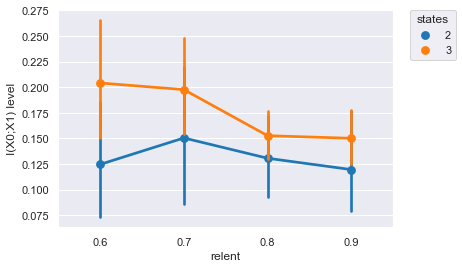

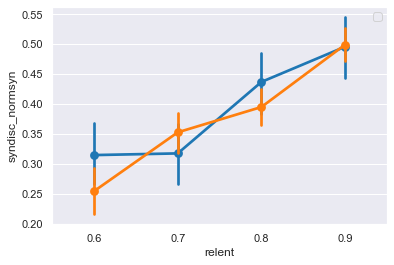

In [35]:
df = pd.read_pickle('../../results/test/sameentmultiplemistates'+str(23)+'.pkl')
y = 'syndisc_normsyn'
hue='states'
sns.pointplot(data=df,y='I(X0;X1) level',x='relent',hue=hue,palette='tab10')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.01,title=hue)
plt.show()
sns.pointplot(data=df,y='syndisc_normsyn',x='relent',hue=hue,palette='tab10',legend=False)
plt.legend([])
plt.show()

## What is best the place to start jointpdf (random,randomsym,bestsym)?

['../../results/rq31\\finalinitialcomparison2.pkl', '../../results/rq31\\finalinitialcomparison3.pkl', '../../results/rq31\\finalinitialcomparison5.pkl', '../../results/rq31\\initialsymbestofallstates4.pkl', '../../results/rq31\\initialsymcomparison4.pkl']


([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

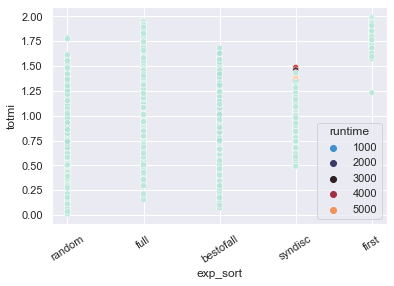

In [2]:
def costfunc(srvparams,jXS,lenJXS,parX,subjects,upper):
    params2matrix_incremental(jXS,parX+list(srvparams))
    totmi = jXS.mutual_information(subjects,[lenJXS-1])
    indivmis = sum([jXS.mutual_information([i],[lenJXS-1]) for i in subjects])
    cost=abs((upper-(totmi-indivmis))/upper)
    if totmi != 0:
        return cost+((indivmis/totmi))
    else:
        return cost+(indivmis)

def costfunc2(srvparams,jXS,lenJXS,parX,subjects,upper):
    params2matrix_incremental(jXS,parX+list(srvparams))
    totmi = jXS.mutual_information(subjects,[lenJXS-1])
    indivmis = sum([jXS.mutual_information([i],[lenJXS-1]) for i in subjects])
    if totmi != 0:
        return (indivmis/totmi)
    else:
        return indivmis+(upper**2)
    
minimize_options = {'ftol': 1e-6}
def symsyninfo(states,lenX,jX,syms,initialtype='first',method=None,costf=costfunc):
    subjects = list(range(lenX))
    parX = matrix2params_incremental(jX)
    upper = synergistic_entropy_upper_bound(jX)
    jXS = append_random_srv(jX,parX,1)
    lenJXS = len(jXS)
    bestsymid=-1
    # get initial guess of best sym
    if initialtype!='random':
        pXSym,bestsymid = addbestsym(lenX,jX,upper,syms)
        jXS.joint_probabilities.joint_probabilities = pXSym

    freeparams = (states**(lenJXS))-(states**(len(jX)))
    symparams = matrix2params_incremental(jXS)[-freeparams:]
    optres_ix = minimize(costf,
                            symparams,method=method,
                            bounds=[(0.0, 1.0)]*freeparams,
#                             callback=(lambda xv: param_vectors_trace.append(list(xv))) if verbose else None,
                            args=(jXS,lenJXS,parX,subjects,upper),options=minimize_options)
    params2matrix_incremental(jXS,parX+list(optres_ix.x))
    return bestsymid,jXS

types = ['random','first','full','syndisc']
types = ['full']

lenX = 2
states = 4
subjects = list(range(lenX))

In [69]:
# dsyndisc.to_pickle("../../results/rq31/finalinitialcomparison"+str(states)+".pkl") 
d

,systemID,parX,upper,totmi,indivmi,runtime,exp_sort,pXS
0,0,"[0.3590497171909354, 0.11355850341573508, 0.56...",1.632260,1.135538,0.000000e+00,2337.367622,syndisc,NaN
1,0,"[0.3590497171909354, 0.11355850341573508, 0.56...",1.632260,1.903446,4.018003e-01,10.030188,full,NaN
2,1,"[0.1294504299176155, 0.18790280890031022, 0.33...",1.967865,1.486538,0.000000e+00,4292.292799,syndisc,NaN
3,1,"[0.1294504299176155, 0.18790280890031022, 0.33...",1.967865,2.078999,2.101465e-01,9.981325,full,NaN
4,2,"[0.06642835500230536, 0.17989089697170002, 0.3...",1.902618,1.461206,0.000000e+00,3491.767141,syndisc,NaN
5,2,"[0.06642835500230536, 0.17989089697170002, 0.3...",1.902618,2.040764,2.412442e-01,10.047599,full,NaN
6,3,"[0.26703288179722273, 0.3098014422236892, 0.55...",1.835324,1.350932,0.000000e+00,3286.386577,syndisc,NaN
7,3,"[0.26703288179722273, 0.3098014422236892, 0.55...",1.835324,2.011108,3.496709e-01,10.003284,full,NaN
8,4,"[0.08202241358032285, 0.10396434560876551, 0.3...",1.734344,1.265440,0.000000e+00,2824.525631,syndisc,NaN
9,4,"[0.08202241358032285, 0.10396434560876551, 0.3...",1.734344,2.062913,4.844345e-01,10.062772,full,NaN


In [3]:
data = {'systemID':[],'parX':[],'upper':[],'totmi':[],'indivmi':[],'runtime':[],'exp_sort':[]}

samples = 3
cursyms = syms
for i in range(samples):
    print(i,time.strftime("%H:%M:%S", time.localtime()))
    jX = JointProbabilityMatrix(lenX,states)
    upper = synergistic_entropy_upper_bound(jX)
    pX = jX.joint_probabilities.joint_probabilities
    parX = matrix2params_incremental(jX)
    for t in types:
        if t !='syndisc':
#             if t == 'full':
#                 cursyms = syms[cs['full sym']]
#             elif t == 'bestofall':
#                 cursyms = syms[cs['full sym']+cs['noisy sym']]
#             elif t=='first':
#                 cursyms = [syms[0]]
#             else:
#                 cursyms = syms
            
            before = time.time()
            best, jXS = symsyninfo(states,lenX,jX,\
                   cursyms,initialtype=t,costf=costfunc)
            data['runtime'].append(time.time()-before)
            data['indivmi'].append(sum([jXS.mutual_information([s],[lenX]) for s in subjects]))
            data['totmi'].append(jXS.mutual_information(subjects,[lenX]))
            data['exp_sort'].append(t+'_cost')
            data['systemID'].append(i)
            data['upper'].append(upper)
            data['parX'].append(parX)
        else:
            ditjX = dit.Distribution.from_ndarray(pX)
            before = time.time()
            syn, probs = self_disclosure_channel(ditjX)
            data['runtime'].append(time.time()-before)
            data['indivmi'].append(0)
            data['totmi'].append(syn)
            data['exp_sort'].append(t)
            data['systemID'].append(i)
            data['upper'].append(upper)
            data['parX'].append(parX)

initialdata = pd.DataFrame(data=data)
initialdata.to_pickle("../../results/test/initialfullstates"+str(states)+".pkl") 
initialdata

0 18:23:51


C:\Users\enrik\Desktop\Mabomba\Studie\MasterCS\Thesis\code\jointpdfpython3\JointProbabilityMatrix.py:527: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item == 'all':


1 18:24:03
2 18:24:15
3 18:24:26
4 18:24:37
5 18:24:48
6 18:24:59
7 18:25:11
8 18:25:22
9 18:25:34
10 18:25:45
11 18:25:55
12 18:26:05
13 18:26:16
14 18:26:27
15 18:26:39
16 18:26:52
17 18:27:06
18 18:27:23
19 18:27:36
20 18:27:49
21 18:28:01
22 18:28:13
23 18:28:24
24 18:28:35
25 18:28:46
26 18:28:57
27 18:29:08
28 18:29:20
29 18:29:30
30 18:29:42
31 18:29:53
32 18:30:05
33 18:30:17
34 18:30:28
35 18:30:40
36 18:30:51
37 18:31:02
38 18:31:13
39 18:31:24
40 18:31:37
41 18:31:48
42 18:32:00
43 18:32:11
44 18:32:22
45 18:32:34
46 18:32:45
47 18:32:55
48 18:33:06
49 18:33:18


,systemID,parX,upper,totmi,indivmi,runtime,exp_sort
0,0,"[0.10633100852979259, 0.1389539905279416, 0.34...",1.867073,2.094035,0.375676,12.419342,full_cost
1,1,"[0.2543768484141622, 0.13506589314880482, 0.38...",1.793545,2.002517,0.400020,11.468698,full_cost
2,2,"[0.20689060249831911, 0.10879693163780889, 0.2...",1.686842,2.010501,0.496264,10.980403,full_cost
3,3,"[0.3143153573569102, 0.10045970825112169, 0.52...",1.815421,2.057652,0.420089,10.961647,full_cost
4,4,"[0.0753031036256971, 0.11225913700155736, 0.21...",1.877064,2.150382,0.414940,11.336903,full_cost
5,5,"[0.08268825226153885, 0.19202554978847433, 0.3...",1.918408,2.168122,0.413655,11.290949,full_cost
6,6,"[0.26455169385162797, 0.3091851512602448, 0.32...",2.018500,2.147146,0.234660,11.530202,full_cost
7,7,"[0.17789302375364857, 0.19687514735621986, 0.2...",1.643229,1.976929,0.536644,11.150212,full_cost
8,8,"[0.1934208728809362, 0.4473936024367996, 0.312...",1.937977,2.136831,0.318419,11.703451,full_cost
9,9,"[0.04682450051501916, 0.5270064113898424, 0.38...",1.621640,1.985957,0.613597,10.809551,full_cost


## Initialsym with previous data

In [3]:
initialdata = pd.read_pickle("../../results/test/initialfullstates"+str(states)+".pkl")
data = {'systemID':[],'parX':[],'upper':[],'totmi':[],'indivmi':[],'runtime':[],'exp_sort':[]}
syns = initialdata[initialdata['exp_sort']=='full_cost']
pars = syns['parX'].values
types = ['full']
cursyms = syms
for i,p in enumerate(pars):
    print(i,time.strftime("%H:%M:%S", time.localtime()))
    jX = JointProbabilityMatrix(lenX,states)
    params2matrix_incremental(jX,p)
    pX = jX.joint_probabilities.joint_probabilities
    upper = synergistic_entropy_upper_bound(jX)
    for t in types:
        if t !='syndisc':
            before = time.time()
            best, jXS = symsyninfo(states,lenX,jX,\
                   cursyms,initialtype=t,costf=costfunc2)
            data['runtime'].append(time.time()-before)
            data['indivmi'].append(sum([jXS.mutual_information([s],[lenX]) for s in subjects]))
            data['totmi'].append(jXS.mutual_information(subjects,[lenX]))
            data['exp_sort'].append(t+'_costupper')
            data['systemID'].append(i)
            data['upper'].append(upper)
            data['parX'].append(p)

initialdata = pd.DataFrame(data=data)
initialdata.to_pickle("../../results/test/initialfullstates"+str(states)+"-2.pkl") 


0 23:43:33


C:\Users\enrik\Desktop\Mabomba\Studie\MasterCS\Thesis\code\jointpdfpython3\JointProbabilityMatrix.py:527: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item == 'all':


1 23:45:03
2 23:46:55
3 23:48:02
4 23:48:46
5 23:49:02
6 23:49:39
7 23:51:19
8 23:51:37
9 23:52:45
10 23:53:01
11 23:54:18
12 23:55:54
13 23:58:03
14 23:59:01
15 23:59:31
16 23:59:45
17 00:03:34
18 00:05:22
19 00:05:50
20 00:07:39
21 00:08:15
22 00:08:56
23 00:09:56
24 00:10:12
25 00:12:21
26 00:12:40
27 00:13:30
28 00:14:04
29 00:14:20
30 00:14:54
31 00:15:11
32 00:18:08
33 00:18:24
34 00:18:57
35 00:19:16
36 00:20:40
37 00:21:23
38 00:22:32
39 00:23:28
40 00:23:45
41 00:24:25
42 00:28:30
43 00:28:45
44 00:32:15
45 00:34:26
46 00:34:42
47 00:37:25
48 00:37:42
49 00:38:25


## Load & plot initialsym data

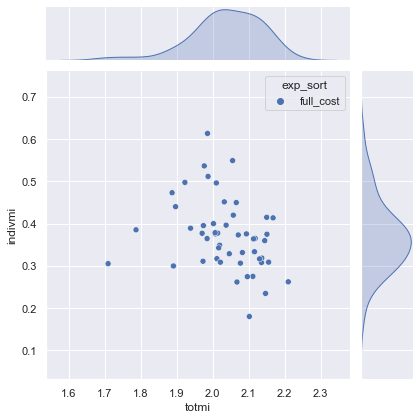

In [5]:
initialdata = pd.read_pickle("../../results/test/initialfullstates"+str(states)+".pkl")
# initialdata2 = pd.read_pickle("../../results/test/initialfullstates"+str(states)+"-2.pkl")
# initialdata3 = pd.read_pickle("../../results/test/initialfullstates"+str(states)+"-3.pkl")
# dats = [initialdata,initialdata2,initialdata3]
# dats = [initialdata,initialdata2]
# initialdata=pd.concat(dats)

plot = initialdata
sns.jointplot(data=plot,x='totmi',y='indivmi',hue='exp_sort')